In [109]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

MLPRegressor(early_stopping=True, hidden_layer_sizes=(1000, 1000),
             learning_rate='adaptive', max_iter=1000, tol=1e-08)

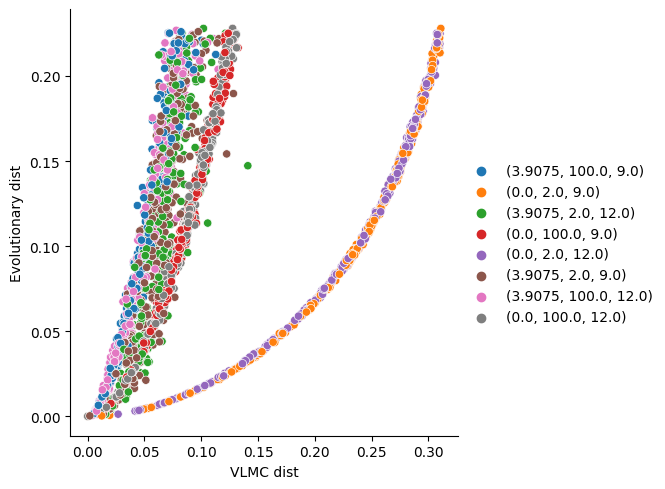

In [110]:
data = pd.read_csv("csv_files/wuhan_65534_distances.csv")
data['VLMC dist'] = data['VLMC dist'].fillna(0)
data = data.drop(['Sequence', 'Unnamed: 0.1', 'Unnamed: 0', 'Original VLMC size', 'Mod VLMC size'], axis=1)

data = data[data['threshold'].isin([0.0, 3.9075])]
data = data[data['min_count'].isin([2, 100])]

# Create feature set and drop NaNs
X = data.drop('Evolutionary dist', axis=1)

# Create ground truth set
y = data['Evolutionary dist']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()

sns.relplot(data=X_test, x='VLMC dist', y=y_test, hue=X_test[['threshold', 'min_count', 'max_depth']].apply(tuple, axis=1))

mlp = MLPRegressor(hidden_layer_sizes=(1000, 1000), learning_rate='adaptive', tol=1e-8, early_stopping=True, max_iter=1000)

mlp.fit(X_train_scaled, y_train_scaled)

Coefficient of determination: 0.9281650877261827
Spearman R: SignificanceResult(statistic=0.9642271086376069, pvalue=0.0)
Mean squared error: 0.000295438660209756


<Axes: >

<Figure size 1200x1000 with 0 Axes>

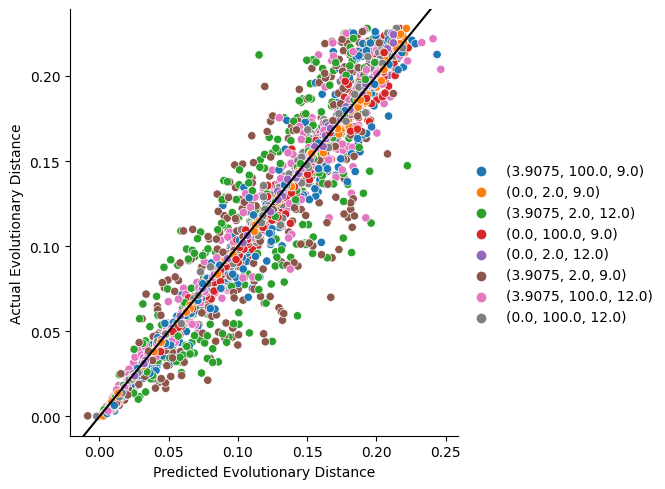

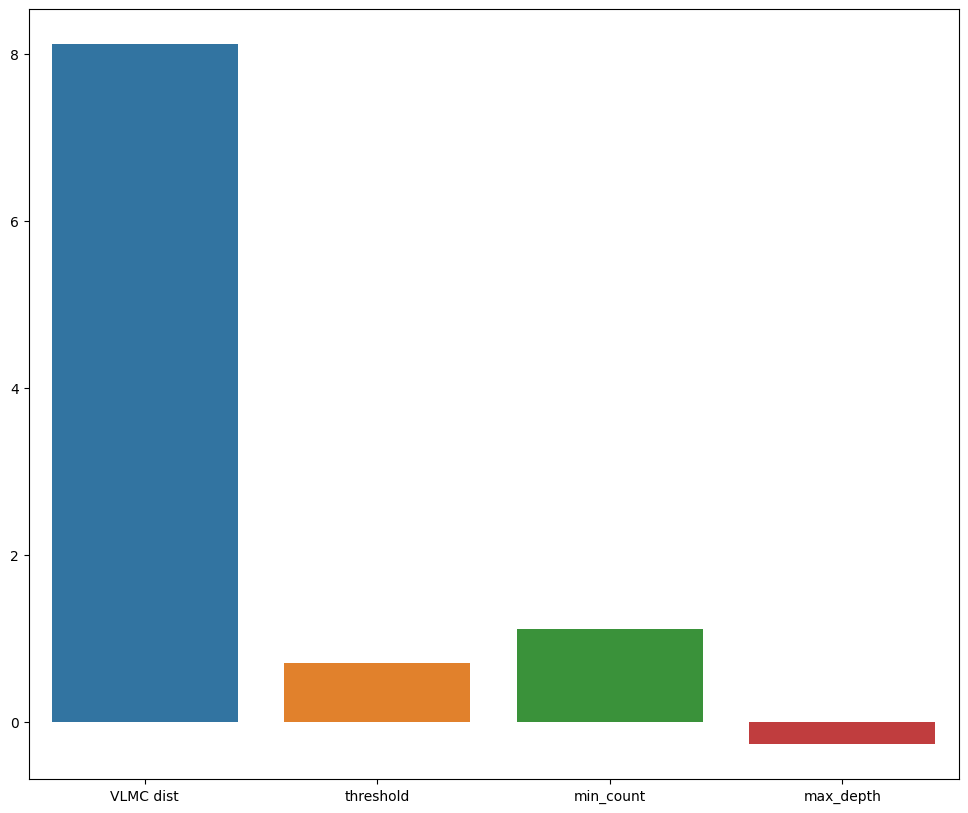

In [111]:
y_pred_scaled = mlp.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

print(f"Coefficient of determination: {mlp.score(np.array(X_test_scaled).reshape(-1,len(X.columns)), y_test_scaled)}")
print(f"Spearman R: {spearmanr(y_pred, y_test)}")
print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")

X_test['Actual Evolutionary Distance'] = y_test.values
X_test['Predicted Evolutionary Distance'] = pd.Series(y_pred).values

plt.figure(figsize=(12,10))
sns.relplot(data=X_test, x='Predicted Evolutionary Distance', y='Actual Evolutionary Distance', hue=X_test[['threshold', 'min_count', 'max_depth']].apply(tuple, axis=1))
plt.axline(xy1=(0,0), slope=1, c='black')

r = mlp.coefs_[0]

for coefs in mlp.coefs_[1:]:
    r = np.matmul(r, coefs)

plt.figure(figsize=(12,10))
sns.barplot(x=X.columns, y=r.flatten())

Coefficient of determination: 0.41150667320063317
Spearman R: SignificanceResult(statistic=0.6308179303862619, pvalue=6.4862598217635935e-273)
Mean squared error: 0.0024203228556785973


<Figure size 1200x1000 with 0 Axes>

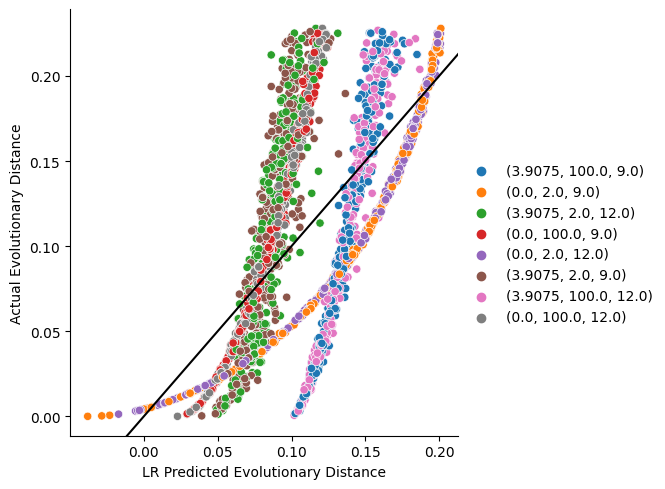

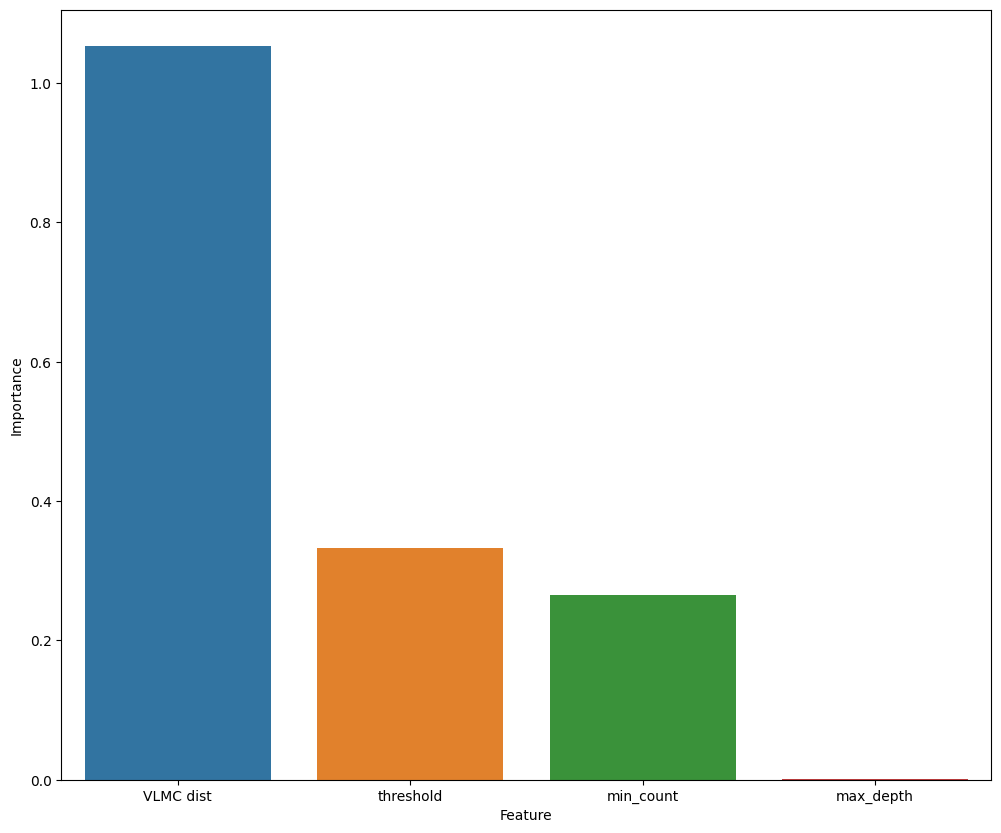

In [116]:
regr = LinearRegression().fit(X_train_scaled, y_train_scaled)

y_pred_lr = regr.predict(np.array(X_test_scaled).reshape(-1, len(X.columns)))
y_pred_lr_d = scaler_y.inverse_transform(y_pred_lr.reshape(-1,1)).flatten()

print(f"Coefficient of determination: {regr.score(np.array(X_test_scaled).reshape(-1, len(X.columns)), y_test_scaled)}")
print(f"Spearman R: {spearmanr(y_pred_lr_d, y_test)}")
print(f"Mean squared error: {mean_squared_error(y_test, y_pred_lr_d)}")

X_test['LR Predicted Evolutionary Distance'] = pd.Series(y_pred_lr_d).values

plt.figure(figsize=(12,10))
sns.relplot(data=X_test, x='LR Predicted Evolutionary Distance', y='Actual Evolutionary Distance', hue=X_test[['threshold', 'min_count', 'max_depth']].apply(tuple, axis=1))
plt.axline(xy1=(0,0), slope=1, c='black')

plt.figure(figsize=(12,10))
sns.barplot(x=X.columns, y=regr.coef_)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()